In [1]:
import pandas
import numpy 
import glob
from matplotlib import pyplot as plt
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

# Importing and Visualizing the Data

## Data Classes

We'll need to make a couple of classes for our imported data that will be used with both gesture recogntion methods. The `Data` class holds the data for a gesture from either the accelerometer or gyroscope. Since each gesture has data from both sensors, the `Gesture` class contains two instances of the `Data` class, one for each sensor for every given gesture 

In [2]:
# class that holds the data of a gesture, either accel or gyro
class Data:
    def __init__(self, sensor_type, current_time, timestamp, x, y, z):
        
        self.sensor_type = sensor_type
        self.current_time = current_time
        self.timestamp = timestamp
        
        # save x y z as float type 
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
        self.mag = numpy.sqrt(self.x**2 + self.y**2 + self.z**2)

    # very useful function to add 0s to the end of an array from Jon Froehlich 
    def pad_with_zeros(self, new_len):
        self.prev_len = len(self.x)
        diff = new_len - len(self.x)
        if diff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(new_len, len(self.x)))
    
        self.x = numpy.pad(self.x, (0, diff), 'constant', constant_values=0)
        self.y = numpy.pad(self.y, (0, diff), 'constant', constant_values=0)
        self.z = numpy.pad(self.z, (0, diff), 'constant', constant_values=0)
        self.mag = numpy.pad(self.mag, (0, diff), 'constant', constant_values=0)
        
        
# class that holds the two accel and gyro Data objects for each gesture trial
class Gesture:
    def __init__(self, gesture_name, end_time, id_number, accel, gyro):
        
        # our two Data objects for the trial
        self.acceleration = accel
        self.gyroscope = gyro
        
        self.delta_x_accel = self.acceleration.x.max() - self.acceleration.x.min()
        self.gesture_name = gesture_name
        self.end_time = end_time
        self.id_number = id_number


### Loading in the Data

Now, we import the csv data and create instances of the classes above. This function will take in a list of the raw csv data and converts it into the relevant class instances in dictionaries.

In [3]:
import platform

# function to create class instances given csv data
def load_data(data_list):
    
    data_result = defaultdict(list)
    gestures = set()
    
    # load data into an array 
    for file in data_list:
        if platform.system() == 'Windows':
            cleaned_file = file.split("\\")[1].split(".")
        else:
            cleaned_file = file.split("/")[1].split(".")
        split_name = cleaned_file[0].split("_")
        this_gesture = split_name[0]
        this_sensor = split_name[1]
        this_time = int(split_name[2])

        this_data = pandas.read_csv(file, skipinitialspace=True)
    
        gestures.add((this_gesture, this_time))
        data_result[(this_gesture, this_time)].append({"data": this_data,"gesture": this_gesture,"sensor": this_sensor,"time": this_time})

    cleaned_data_result = defaultdict(list)
    gesture_counts = defaultdict(int)
    longest_sensor_data_list = 0
    
    for gesture in gestures:
        gesture_counts[gesture[0]] = gesture_counts[gesture[0]] + 1
        new = []
    
        for i in data_result[gesture]:
            d = Data(i['sensor'], i['time'], i['data']['SensorTimestampNano'], i['data']['X'], i['data']['Y'], i['data']['Z'])
            new.append(d)
            
            if len(d.x) > longest_sensor_data_list:
                longest_sensor_data_list = len(d.x)
        
        cleaned_data_result[gesture[0]].append(Gesture(gesture[0], gesture[1], gesture_counts[gesture[0]], new[0], new[1]))

    
    for gesture in cleaned_data_result:
        for obj in cleaned_data_result[gesture]:
            # resize the data arrays to match the longest
            obj.acceleration.pad_with_zeros(longest_sensor_data_list)
            obj.gyroscope.pad_with_zeros(longest_sensor_data_list)
            #print({obj.gesture_name, obj.id_number})
            
    return cleaned_data_result

Now, we can load in the csv files and create the dictionaries of data.

In [4]:
provided_files = glob.glob("providedGestureLogs/*.csv")
collected_files = glob.glob("recordedGestureLogs/*.csv")

cleaned_provided_data = load_data(provided_files)
cleaned_recorded_data = load_data(collected_files)

Now, we have all the data loaded into a dictionary with keys that correspond to the names of the gestures. So, I could say `cleaned_provided_data['Backhand Tennis']` to access the list of each of the backhand tennis trials. 

### Cleaning up the Data

I'm going to detrend the magnitude data for all of the gestures to try and normalize the signals. I'm just doing this for the acceleration data, since this is what I'll use in the classifiers below. 

In [5]:
from scipy import signal
import warnings
# hiding some useless warning
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

for gesture in cleaned_provided_data:
    for obj in cleaned_provided_data[gesture]:
        obj.mag = signal.detrend(obj.acceleration.mag)
        
for gesture in cleaned_recorded_data:
    for obj in cleaned_recorded_data[gesture]:
        obj.mag = signal.detrend(obj.acceleration.mag)

## Visualizing the Gesture Sets

Using `matplotlib` we'll create visualizations of each of the gestures' raw acceleration signal data. 

### Recorded Gesture Set

I'll plot each of the gestures from the data set that I recorded. 

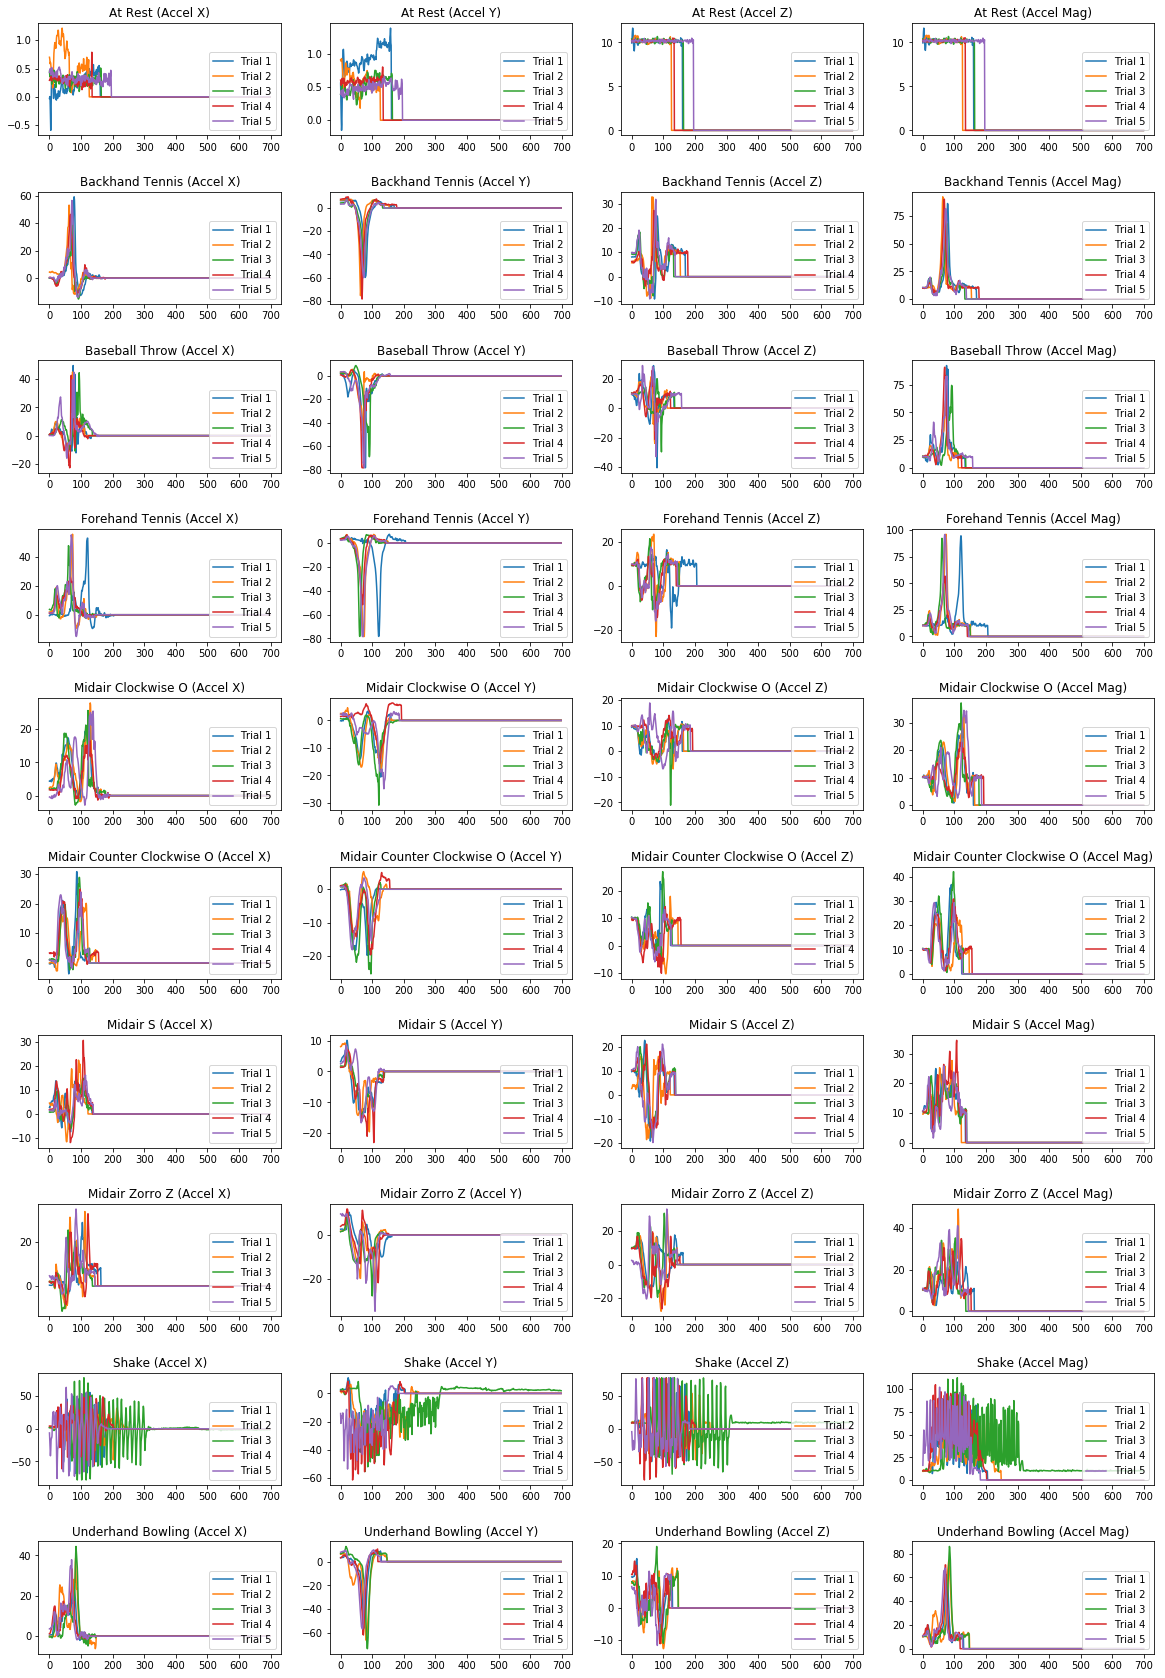

In [6]:
# the organization of these plots is from Jon Froehlich
fig, ax = plt.subplots(len(cleaned_recorded_data), 4, figsize=(20, 3 * len(cleaned_recorded_data)))
fig.subplots_adjust(hspace=0.5)

index = 0
gesture_names = sorted(cleaned_recorded_data.keys())

for gesture in gesture_names:
    trials = cleaned_recorded_data[gesture]
    trialNum = 1
    
    for trial in trials:
        ax[index][0].plot(trial.acceleration.x, label="Trial {}".format(trialNum))
        ax[index][1].plot(trial.acceleration.y, label="Trial {}".format(trialNum))
        ax[index][2].plot(trial.acceleration.z, label="Trial {}".format(trialNum))
        ax[index][3].plot(trial.acceleration.mag, label="Trial {}".format(trialNum))
        trialNum += 1
        
    ax[index][0].set_title(gesture + " (Accel X)")
    ax[index][0].legend(loc=4)
    ax[index][1].set_title(gesture + " (Accel Y)")
    ax[index][1].legend(loc=4)
    ax[index][2].set_title(gesture + " (Accel Z)")
    ax[index][2].legend(loc=4)
    ax[index][3].set_title(gesture + " (Accel Mag)")
    ax[index][3].legend(loc=4)
    index += 1

### Comparing Provided and Recorded Gesture Sets

There are two gesture sets, so I'd like to compare them. Chances are how each gesture was recorded in each set was different, so here I visualize some of those differences. 

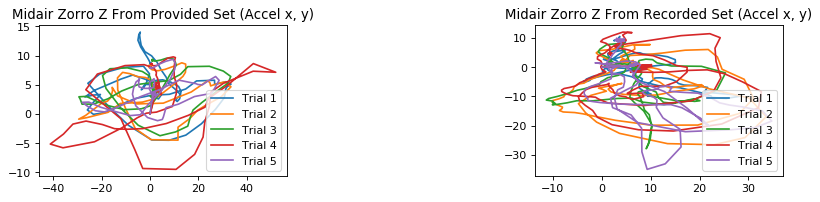

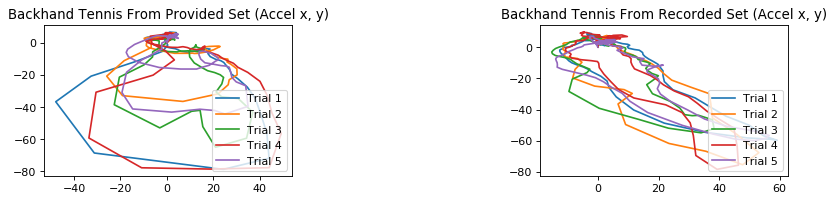

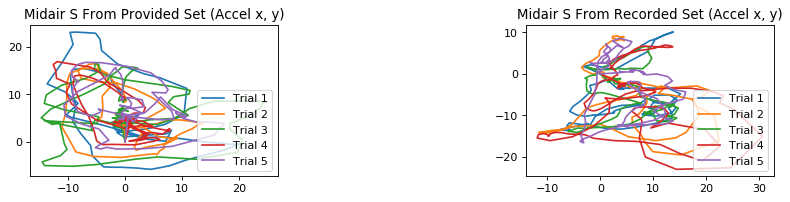

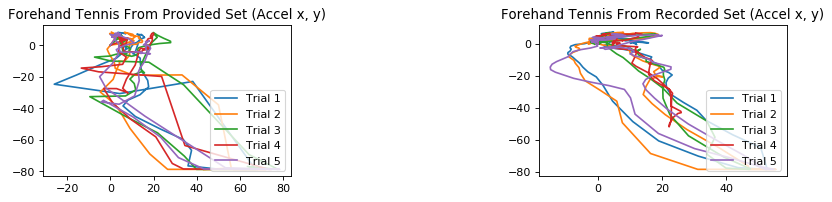

In [8]:
def plot_both_sets(gesture):

    fig = plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    fig.subplots_adjust(wspace = 1, hspace=0.4)

    ax = fig.add_subplot(2, 2, 1)
    trials = cleaned_provided_data[gesture]
    trialNum = 1
    
    for trial in trials:
        ax.plot(numpy.array(trial.acceleration.x), 
                numpy.array(trial.acceleration.y), label="Trial {}".format(trialNum))
        trialNum += 1
        
    ax.set_title("{} From Provided Set (Accel x, y)".format(gesture))
    ax.legend(loc=4)

    ax = fig.add_subplot(2, 2, 2)
    trials = cleaned_recorded_data[gesture]
    trialNum = 1
    
    for trial in trials:
        ax.plot(numpy.array(trial.acceleration.x), 
                numpy.array(trial.acceleration.y), label="Trial {}".format(trialNum))
        trialNum += 1
        
    ax.set_title("{} From Recorded Set (Accel x, y)".format(gesture))
    ax.legend(loc=4)

    plt.show()

# now we can plot the sets of gestures
plot_both_sets('Midair Zorro Z')
plot_both_sets('Backhand Tennis')
plot_both_sets('Midair S')
plot_both_sets('Forehand Tennis')

Clearly, there are differences in the two sets, but they are similar enough to be able to use to train and test the same classifiers.

### Gesture Characteristics

Now, lets take a look at some of the characteristics of each gesture. First, I'm going to calculate the average maximum magnitude of the acceleration data and gyroscope data for each gesture, and compare the two sensors. 

In [7]:
# calculate the average of magnitude for each gesture

acceleration_for_mag = defaultdict(int)
gyrometer_for_mag = defaultdict(int)

for gesture in cleaned_provided_data:
    
    avg_gyro = 0
    avg_accel = 0
    denom = 0
    
    for i in cleaned_provided_data[gesture]:

        denom += 1
        avg_accel += i.acceleration.mag.max()
        avg_gyro += i.gyroscope.mag.max()
    
    avg_accel = avg_accel / denom
    avg_gyro = avg_gyro / denom
    
    acceleration_for_mag[gesture] = avg_accel
    gyrometer_for_mag[gesture] = avg_gyro
    

print("Average Max Acceleration Magnitude")
for gesture in acceleration_for_mag:
    print("{}, {}".format(acceleration_for_mag[gesture], gesture,))
    
print("\nAverage Max Gyrometer Magnitude")
for gesture in gyrometer_for_mag:
    print("{}, {}".format(gyrometer_for_mag[gesture], gesture,))

Average Max Acceleration Magnitude
23.777120162782417, Midair Clockwise O
100.22058141182768, Underhand Bowling
114.25636187179391, Forehand Tennis
39.545109994585616, Midair Zorro Z
10.167828431068617, At Rest
35.68223693398437, Midair Counter Clockwise O
114.89483746826423, Baseball Throw
81.75566731307991, Backhand Tennis
27.965769187661216, Midair S
76.42042179541794, Shake

Average Max Gyrometer Magnitude
5.223955883337801, Midair Clockwise O
11.184870740487368, Underhand Bowling
11.728835076849263, Forehand Tennis
4.594155591325856, Midair Zorro Z
0.1438979281095814, At Rest
11.033358323713792, Midair Counter Clockwise O
11.033612167981513, Baseball Throw
4.585748132459554, Backhand Tennis
9.857917924773616, Midair S
13.326342009454496, Shake


The difference between the average magnitude of the gyroscope data for each gesture is rather small. The acceleration data, on the other hand, is more varied, so we'll use it for future classifications.

## K-Fold Validation

We'll use the `sklearn` version of K-Fold validation. The function calls `KFold` to create a fold. The number of folds produced is given by the folds parameter. For both the DTW and SVM methods, I'll use 5 folds to get 80% of the data for training and the other 20% for testing.

In [10]:

def make_folds(folds, data):
    
    mixed_data = []
    
    # load all gestures into one array 
    for gesture in data:
        for obj in data[gesture]:
            mixed_data.append(obj)
        
    X = numpy.asarray(mixed_data)
    numpy.random.seed(42)
    numpy.random.shuffle(X)

    train = numpy.array_split(X, folds)

    return train


# Dynamic Time Warping + K-Nearest Neighbor Gesture Recognition

We'll use `fastdtw` to for the DTW method. Each test gesture's signal data is compared against each training gesture's signal data. The gesture that has the least distance between itself and the test gesture is the classifier's guess. This method is **really slow**, as each test signal is compared against every signal in the training set. It is, however, very accurate.

In [9]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def DTW_KNN(test_gesture, compare_gestures, compare_gesture_lablels):
    
    smallest_dist = 1000
    label = ''
    index = 0
    matched = None
    
    for gesture in compare_gestures:      
        dist, path = fastdtw(test_gesture, gesture, dist=euclidean)
        
        if dist < smallest_dist:
            smallest_dist = dist
            label = compare_gesture_lablels[index]
            #print(gesture)
            matched = gesture
        index += 1
        
    if label == '':
        label = 'Shake'

    return (label, matched)

Now, we can run the classifier on each of the five folds. 

In [11]:
import copy

training_data = make_folds(5, cleaned_provided_data)
results = []

fold = 0

for test_data_fold in training_data:
    
    training_data_fold = copy.deepcopy(training_data)
    del training_data_fold[fold]
    
    training_mags = []
    training_labels = []
    
    # collect the training data
    for training_fold in training_data_fold:
        
        for gesture in training_fold:
            training_mags.append(gesture.acceleration.mag)
            training_labels.append(gesture.gesture_name)
            
    test = []
    pred = []
    matched_gestures = []
    print("\nTesting fold {}...".format(fold + 1))
    # run the tests 
    for gesture in test_data_fold:
        
        print("Inputting: {}".format(gesture.gesture_name))
        test.append(gesture.gesture_name)
        guess, matched = DTW_KNN(gesture.acceleration.mag, training_mags, training_labels)
    
        if guess == gesture.gesture_name:
            print("✓ DTW_KNN Guess: {}".format(guess))
        else:
            print("✗ DTW_KNN Guess: {}".format(guess))
        pred.append(guess)
        matched_gestures.append(matched)
        
    results.append({'test': test, 'pred': pred})
    fold += 1
        


Testing fold 1...
Inputting: Forehand Tennis
✓ DTW_KNN Guess: Forehand Tennis
Inputting: Backhand Tennis
✓ DTW_KNN Guess: Backhand Tennis
Inputting: Baseball Throw
✓ DTW_KNN Guess: Baseball Throw
Inputting: Shake
✓ DTW_KNN Guess: Shake
Inputting: Midair Zorro Z
✓ DTW_KNN Guess: Midair Zorro Z
Inputting: Shake
✓ DTW_KNN Guess: Shake
Inputting: Midair Counter Clockwise O
✓ DTW_KNN Guess: Midair Counter Clockwise O
Inputting: Midair Counter Clockwise O
✓ DTW_KNN Guess: Midair Counter Clockwise O
Inputting: Baseball Throw
✓ DTW_KNN Guess: Baseball Throw
Inputting: Midair Zorro Z
✗ DTW_KNN Guess: Midair S

Testing fold 2...
Inputting: Forehand Tennis
✓ DTW_KNN Guess: Forehand Tennis
Inputting: Midair Clockwise O
✓ DTW_KNN Guess: Midair Clockwise O
Inputting: Backhand Tennis
✓ DTW_KNN Guess: Backhand Tennis
Inputting: Underhand Bowling
✗ DTW_KNN Guess: Forehand Tennis
Inputting: Midair Clockwise O
✓ DTW_KNN Guess: Midair Clockwise O
Inputting: Underhand Bowling
✓ DTW_KNN Guess: Underhand Bo

### Precision and Recall of DTW + KNN

Now, we compute the overall accuracy of the DTW + KNN approach. I'm computing a confusion matrix as well as the precision and recall of the classifier.

                            precision    recall  f1-score   support

                   At Rest       1.00      1.00      1.00         5
           Backhand Tennis       1.00      1.00      1.00         5
            Baseball Throw       1.00      1.00      1.00         5
           Forehand Tennis       0.83      1.00      0.91         5
        Midair Clockwise O       1.00      1.00      1.00         5
Midair Counter Clockwise O       1.00      1.00      1.00         5
                  Midair S       0.83      1.00      0.91         5
            Midair Zorro Z       1.00      0.80      0.89         5
                     Shake       1.00      1.00      1.00         5
         Underhand Bowling       1.00      0.80      0.89         5

               avg / total       0.97      0.96      0.96        50


Overall Accuracy for DTW + KNN Classifier
0.96


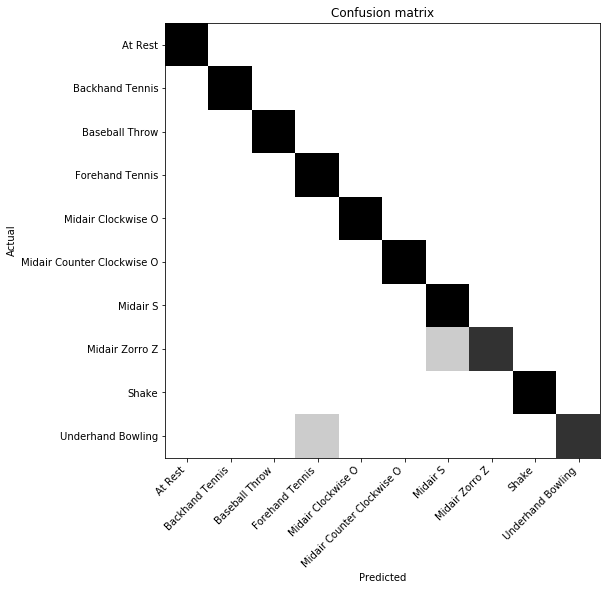

In [12]:
from sklearn.metrics import classification_report, accuracy_score
from pandas_ml import ConfusionMatrix

compiled_test = []
compiled_pred = []

for i in range(0, len(results)):
    compiled_test = compiled_test + results[i]['test']
    compiled_pred = compiled_pred + results[i]['pred']

print (classification_report(compiled_test, compiled_pred))

acc = accuracy_score(compiled_test, compiled_pred, normalize=True)
print("\nOverall Accuracy for DTW + KNN Classifier")
print(acc)

# Plot confusion matrix
cm = ConfusionMatrix(compiled_test, compiled_pred)
cm.plot()
plt.show()


# Model-Based (SVM) Gesture Recognition 

I'm going to be using an svm from sklearn. For the input, I'm going to be using the magnitude from the acceleration sensor for each gesture. For the inputs, I'm using an array composed of the max and min magnitude values, standard deviation of the magnitude, and mean of the magnitude. Each gesture is reduced to an array of these four elements.

In [13]:
from scipy.signal import find_peaks

def create_classification_vector(data):
    res = []
    
    for item in data:
        peaks = len(find_peaks(item.acceleration.mag))
        mag_max_val = item.acceleration.mag.max()
        mag_min_val = item.acceleration.mag.min()
        mag_std_dev = numpy.std(item.acceleration.mag)
        mag_mean = numpy.mean(item.acceleration.mag)
        
        res.append([peaks, mag_max_val, mag_min_val, mag_std_dev, mag_mean])
        
    return res

In [15]:
from sklearn import svm
import copy

training_data = make_folds(5, cleaned_provided_data)
svm_results = []

fold = 0

for test_data_fold in training_data:
    
    training_data_fold = copy.deepcopy(training_data)
    del training_data_fold[fold]
    
    training_gestures = []
    training_labels = []
    
    # collect the training data
    for training_fold in training_data_fold:
        
        for gesture in training_fold:
            training_gestures.append(gesture)
            training_labels.append(gesture.gesture_name)
            
    testing_gestures = []
    testing_labels = []
    
    # make the testing data
    for gesture in test_data_fold:
        testing_gestures.append(gesture)
        testing_labels.append(gesture.gesture_name)
            
    train_vec = create_classification_vector(training_gestures)
    test_vec = create_classification_vector(testing_gestures)

    print("\nTesting fold {}...".format(fold + 1))
    
    clf = svm.SVC()
    clf.fit(train_vec, training_labels) 
    
    i = 0
    pred_labels = []
    
    # run the tests 
    for vec in test_vec:
        
        print("Inputting: {}".format(testing_labels[i]))
        
        guess = clf.predict(numpy.asarray(vec).reshape(1, -1))
        pred_labels.append(guess[0])
    
        if guess[0] == testing_labels[i]:
            print("✓ SVM Guess: {}".format(guess[0]))
        else:
            print("✗ SVM Guess: {}".format(guess[0]))
        
        i += 1
        
    svm_results.append({'test': testing_labels, 'pred': pred_labels})
    fold += 1
        


Testing fold 1...
Inputting: Forehand Tennis
✓ SVM Guess: Forehand Tennis
Inputting: Backhand Tennis
✗ SVM Guess: Underhand Bowling
Inputting: Baseball Throw
✓ SVM Guess: Baseball Throw
Inputting: Shake
✗ SVM Guess: Underhand Bowling
Inputting: Midair Zorro Z
✗ SVM Guess: Midair Counter Clockwise O
Inputting: Shake
✓ SVM Guess: Shake
Inputting: Midair Counter Clockwise O
✗ SVM Guess: Midair Zorro Z
Inputting: Midair Counter Clockwise O
✓ SVM Guess: Midair Counter Clockwise O
Inputting: Baseball Throw
✗ SVM Guess: Underhand Bowling
Inputting: Midair Zorro Z
✗ SVM Guess: Midair S

Testing fold 2...
Inputting: Forehand Tennis
✓ SVM Guess: Forehand Tennis
Inputting: Midair Clockwise O
✗ SVM Guess: Midair S
Inputting: Backhand Tennis
✓ SVM Guess: Backhand Tennis
Inputting: Underhand Bowling
✗ SVM Guess: Baseball Throw
Inputting: Midair Clockwise O
✗ SVM Guess: Backhand Tennis
Inputting: Underhand Bowling
✗ SVM Guess: Backhand Tennis
Inputting: Midair S
✗ SVM Guess: Midair Clockwise O
Input

### Precision and Recall of SVM Method

Now, we compute the overall accuracy of the SVM approach, as before

                            precision    recall  f1-score   support

                   At Rest       1.00      0.80      0.89         5
           Backhand Tennis       0.15      0.40      0.22         5
            Baseball Throw       0.67      0.40      0.50         5
           Forehand Tennis       1.00      0.80      0.89         5
        Midair Clockwise O       0.00      0.00      0.00         5
Midair Counter Clockwise O       0.50      0.60      0.55         5
                  Midair S       0.17      0.20      0.18         5
            Midair Zorro Z       0.00      0.00      0.00         5
                     Shake       0.50      0.40      0.44         5
         Underhand Bowling       0.00      0.00      0.00         5

               avg / total       0.40      0.36      0.37        50


Overall Accuracy for SVM Classifier
0.36


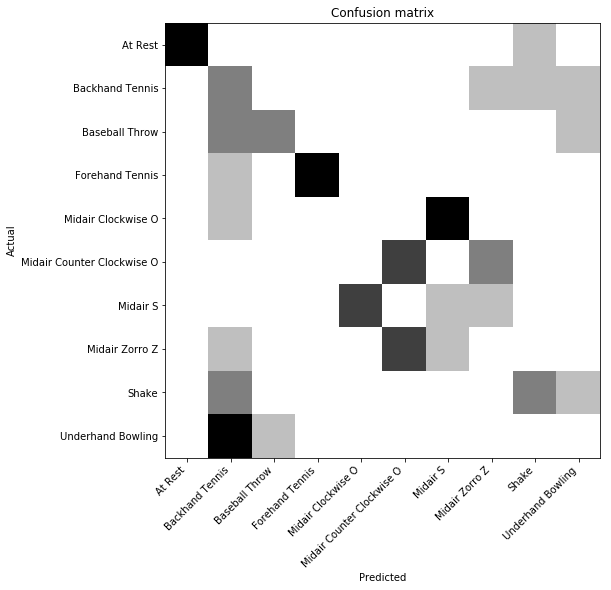

In [16]:
from sklearn.metrics import classification_report, accuracy_score
from pandas_ml import ConfusionMatrix

compiled_test = []
compiled_pred = []

for i in range(0, len(results)):
    compiled_test = compiled_test + svm_results[i]['test']
    compiled_pred = compiled_pred + svm_results[i]['pred']

print (classification_report(compiled_test, compiled_pred))

acc = accuracy_score(compiled_test, compiled_pred, normalize=True)
print("\nOverall Accuracy for SVM Classifier")
print(acc)

# Plot confusion matrix
cm = ConfusionMatrix(compiled_test, compiled_pred)
cm.plot()
plt.show()

# Summary

The DTW gesture recognition approach definitely worked the best, as I was able to get an overall accuracy of 96% (precision of 97% and recall of 96%.) Using the magnitude data for the signals was the best route, as it is a combination of the x, y, and z vectors. Using just one of these dimenstions with the DTW approach was overall less accurate, as there were more variations between gestures that would yield different distances between the signals. However, a big drawback of the DTW approach is that it uses a K-nearest neighbors algorithm for determining the closest signal, which requires that each piece of test data be compared against each piece of training data, which is really slow. 

The SVC method was much less successful, as I was only able to get 36% accuracy (precision of 40% and recall of 36%.) I used the magnitude data once again, training with a vector containing the max, min, standard deviation, and mean of the magnitude signal. The variations between each of the signals of each gesture became more apparent with this method, as the standard deviation and mean of each of the gestures was on average different, but differences between tests of the same gesture were large. This resulted in a really low accuracy. In order for a SVC classifier to work, it might be a good idea to transform each of the signals before training with a fourier transform, in order to minimize some of the random variation between gesture tests.